In [0]:
# import packages

import pystan
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn
import datetime
from datetime import timedelta
%matplotlib inline
np.random.seed(2019)

### **Data Processing**

In [0]:
data = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vTX5nZNL-okv1cEdQ00ue57BEI6ARhDZwMJWiUyD4xupTcIx0aEI75UTxp8P9zxsS3OJxt4O8bVesEk/pub?gid=1807527606&single=true&output=csv", header = None)

In [0]:
data.columns = ["Date", "Amount"]

In [4]:
max(data["Date"])

'2019-09-28'

In [0]:
# subtract the date values from the first date
time = []
for i in range(len(data)):
  time.append((datetime.datetime.strptime(data["Date"][i], "%Y-%m-%d") - datetime.datetime.strptime(data["Date"][0], "%Y-%m-%d")).days)

In [0]:
data["Time"] = time

In [7]:
data.head()

,Date,Amount,Time
0,1958-03-29,316.19,0
1,1958-04-05,317.31,7
2,1958-04-12,317.69,14
3,1958-04-19,317.58,21
4,1958-04-26,316.48,28


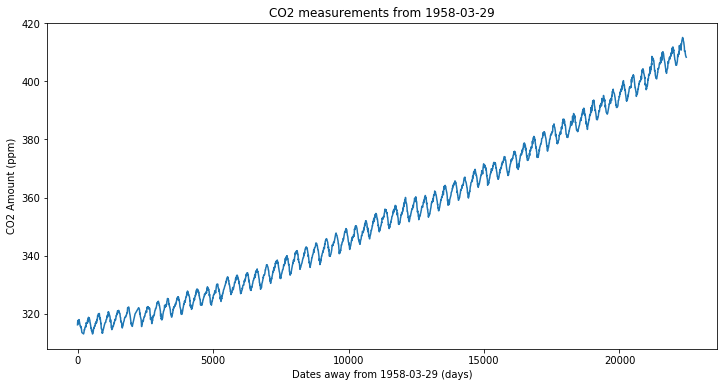

In [8]:
plt.figure(figsize = (12,6))
plt.title('CO2 measurements from 1958-03-29')
plt.plot(data["Time"], data["Amount"], label = "Real data")
plt.xlabel("Dates away from 1958-03-29 (days)")
plt.ylabel("CO2 Amount (ppm)")
plt.show()

### **Simple model**: Linear + cos periodic

In [9]:
# The Stan model. Running this cell compiles the Stan model, which takes
# some time.
  # Stan gets to see the first n data values only

stan_code = """
data {
    int<lower=0> n;        // The number of data
    int<lower=0> n_future; // the number of predictions
    real x[n];             // The data
    real t[n];             // time data
    real t_future[n_future]; // future time data
}

parameters {
    real<lower = 0> c0;
    real<lower = 0> c1;
    real<lower = 0> c2;
    real<lower = 0> c3;
    real<lower = 0> c4;
}

model {
    for(i in 1:n) {
        x[i] ~ normal(
            c0 + c1*t[i] + c2*cos(2*pi()*t[i]/365.25 + c3),
            c4);
    }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real x_future[n_future];
    for(i in 1:n_future) {
        x_future[i] = normal_rng(
            c0 + c1*t_future[i] + c2*cos(2*pi()*t_future[i]/365.25 + c3),
            c4);
    }
}
"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ebe2c6f5518b031d8f01ff4ffba65ddc NOW.


In [10]:
# subsetting the data
n = len(data)*7//10
n_future = len(data) - n

# stan data
stan_data = {
    'n': n,
    'n_future': n_future,
    'x': data["Amount"][:n],
    't': data["Time"][:n],
    "t_future" : data["Time"][n:]}

# Run Hamiltonian Monte Carlo using Stan with 4 Markov chains, a 1000 step
# warm-up phase and 1000 step sampling phase for each chain. The warm-up samples
# are discarded, so we are left with 4 x 1000 = 4000 samples.

# This cell will take a minute or two to run.

parameters = ['c0', 'c1', 'c2', 'c3', 'c4']

results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

Inference for Stan model: anon_model_ebe2c6f5518b031d8f01ff4ffba65ddc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0 310.31  1.4e-3   0.09 310.15 310.25 310.31 310.37 310.48   3822    1.0
c1 3.7e-3  1.6e-7 9.3e-6 3.7e-3 3.7e-3 3.7e-3 3.7e-3 3.7e-3   3546    1.0
c2    2.7    0.09   0.14   2.47   2.58    2.7   2.83   2.94      2   2.39
c3 142.72  148.08 209.46 4.9e-5 7.9e-4  34.31 307.12 502.24      2  1.6e4
c4    2.0    0.07    0.1   1.87   1.91   2.01   2.09   2.15      2   3.39

Samples were drawn using NUTS at Wed Dec 18 13:51:30 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


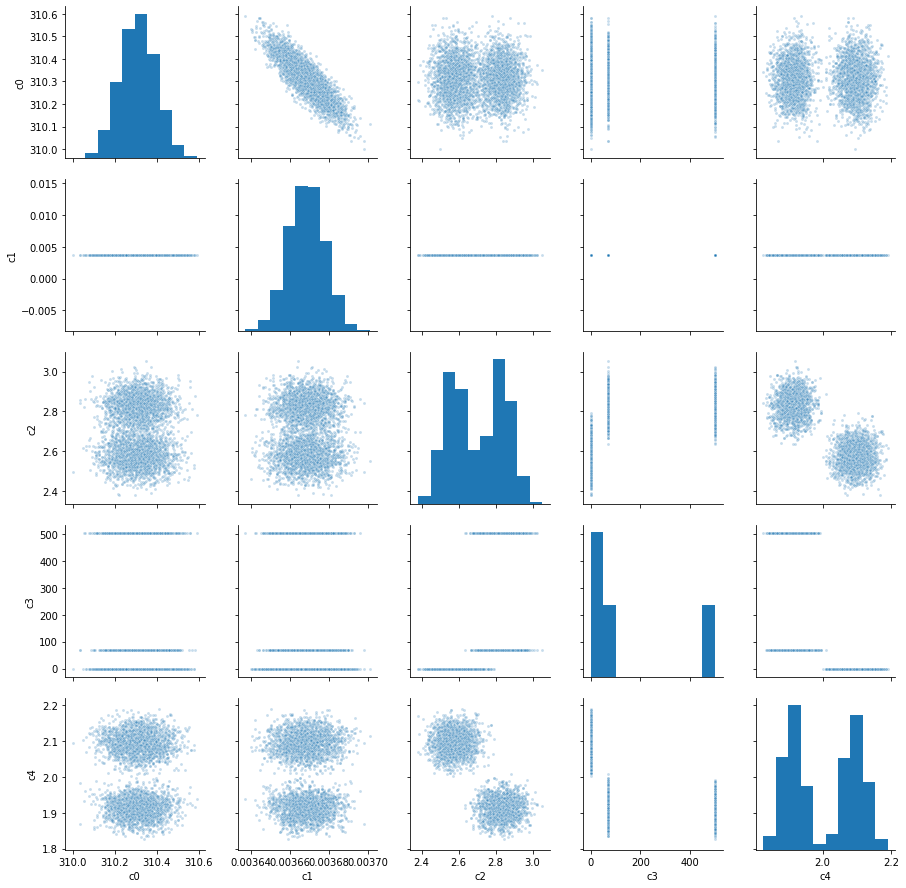

In [11]:
# plot the pair plot

df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

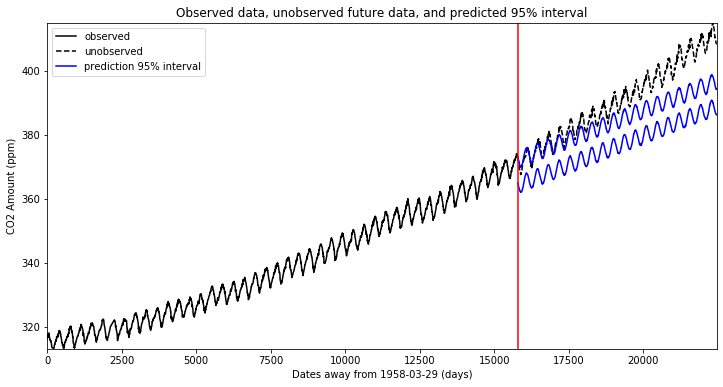

In [12]:
# draw predictions
prediction = samples['x_future']

# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
# observed data
plt.plot(data["Time"][:n], data["Amount"][:n], 'k-', label='observed')
#unobserved data
plt.plot(data["Time"][n:n+n_future], data["Amount"][n:n+n_future], 'k--', label='unobserved')

# set the grid
plt.xlim(0, data["Time"][n+n_future-1])
plt.ylim(
    min(min(prediction[0,:]), min(data["Amount"])),
    max(max(prediction[1,:]), max(data["Amount"])))

# confidence interval
plt.plot(
    data["Time"][n:],
    prediction_interval[0,:],
    'b-', label='prediction 95% interval')
plt.plot(
    data["Time"][n:],
    prediction_interval[1,:],
    'b-')

plt.axvline(data["Time"][n - 1], color='red')
plt.xlabel("Dates away from 1958-03-29 (days)")
plt.ylabel("CO2 Amount (ppm)")
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()

### **Revised model**: quadratic + cos periodic

In [13]:
# The Stan model. Running this cell compiles the Stan model, which takes
# some time.
  # Stan gets to see the first n data values only

stan_code = """
data {
    int<lower=0> n;        // The number of data
    int<lower=0> n_future; // the number of predictions
    real x[n];             // The data
    real t[n];             // time data
    real t_future[n_future]; // future time data
}

parameters {
    real<lower = 0> c0;
    real<lower = 0> c1;
    real<lower = 0> c2;
    real<lower = 0, upper = pi()> c3;
    real<lower = 0> c4;
    real<lower = 0> c5;
}

model {
    for(i in 1:n) {
        x[i] ~ normal(
            c0 + c1*t[i] + c5*t[i]*t[i] + c2*cos(2*pi()*t[i]/365.25 + c3),
            c4);
    }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real x_future[n_future];
    for(i in 1:n_future) {
        x_future[i] = normal_rng(
            c0 + c1*t_future[i] + c5*t_future[i]*t_future[i] + c2*cos(2*pi()*t_future[i]/365.25 + c3),
            c4);
    }
}
"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_84f7f23059da5ade2b15b1965e6fdfad NOW.


In [14]:
# subsetting the data
n = len(data)*7//10
n_future = len(data) - n

stan_data = {
    'n': n,
    'n_future': n_future,
    'x': data["Amount"][:n],
    't': data["Time"][:n],
    "t_future" : data["Time"][n:]}

# Run Hamiltonian Monte Carlo using Stan with 4 Markov chains, a 1000 step
# warm-up phase and 1000 step sampling phase for each chain. The warm-up samples
# are discarded, so we are left with 4 x 1000 = 4000 samples.

# This cell will take a minute or two to run.

parameters = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5']

results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

Inference for Stan model: anon_model_84f7f23059da5ade2b15b1965e6fdfad.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
c0 314.23  1.8e-3   0.09 314.06 314.17 314.23 314.28 314.39   2307    1.0
c1 2.2e-3  5.8e-7 2.4e-5 2.2e-3 2.2e-3 2.2e-3 2.2e-3 2.3e-3   1763    1.0
c2   2.54  6.7e-4   0.04   2.46   2.51   2.54   2.56   2.61   3226    1.0
c3 5.0e-4  8.4e-6 4.7e-4 1.3e-5 1.6e-4 3.6e-4 6.8e-4 1.7e-3   3097    1.0
c4   1.28  3.7e-4   0.02   1.24   1.26   1.28   1.29   1.32   2875    1.0
c5 9.0e-8 3.5e-11 1.5e-9 8.7e-8 8.9e-8 9.0e-8 9.1e-8 9.3e-8   1715    1.0

Samples were drawn using NUTS at Wed Dec 18 13:59:27 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


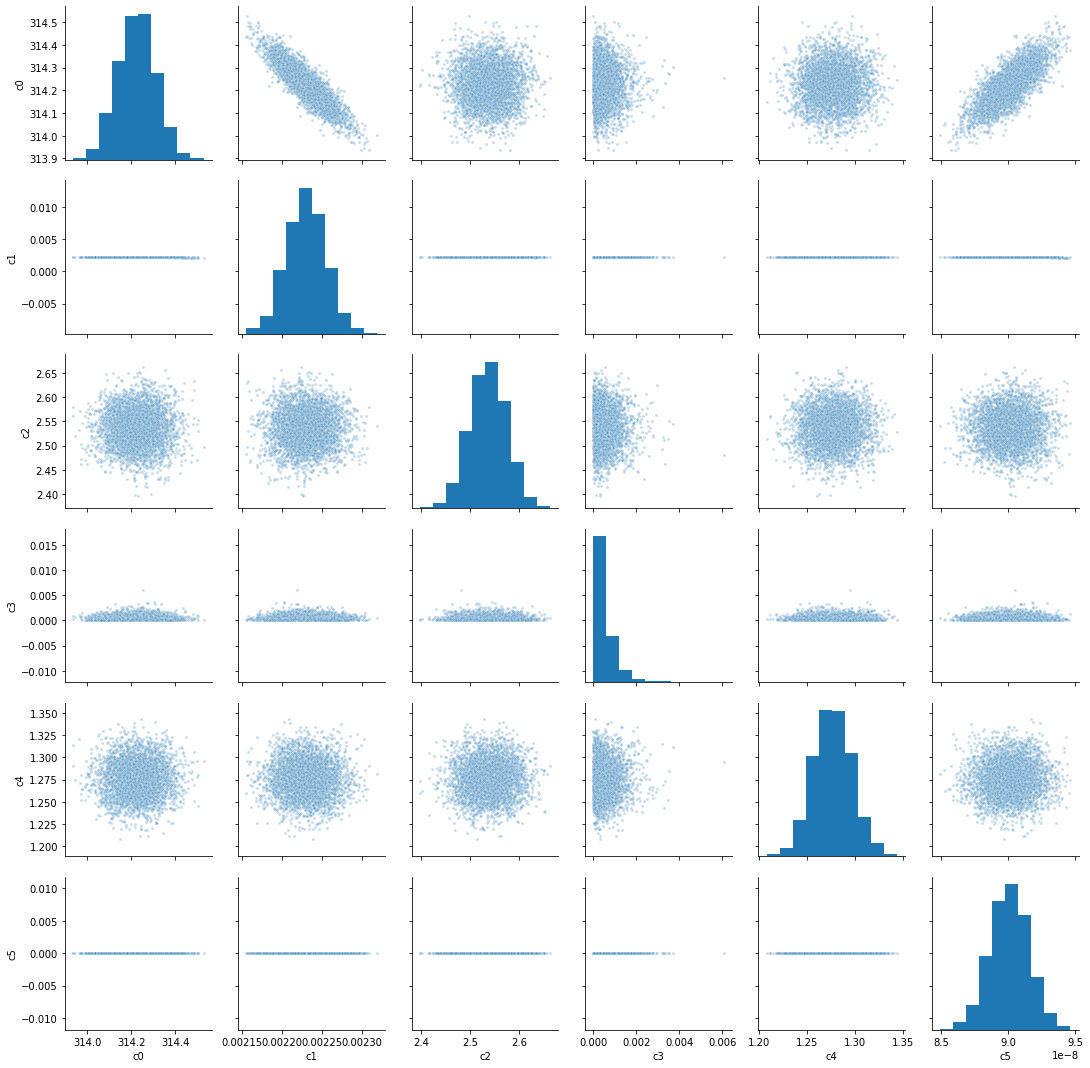

In [15]:
# pair plots

df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

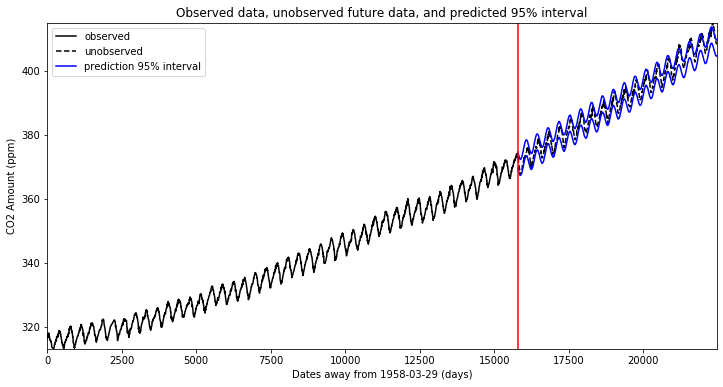

In [16]:
# draw predictions
prediction = samples['x_future']

# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(data["Time"][:n], data["Amount"][:n], 'k-', label='observed')
plt.plot(data["Time"][n:n+n_future], data["Amount"][n:n+n_future], 'k--', label='unobserved')
plt.xlim(0, data["Time"][n+n_future-1])
plt.ylim(
    min(min(prediction[0,:]), min(data["Amount"])),
    max(max(prediction[1,:]), max(data["Amount"])))
plt.plot(
    data["Time"][n:],
    prediction_interval[0,:],
    'b-', label='prediction 95% interval')
plt.plot(
    data["Time"][n:],
    prediction_interval[1,:],
    'b-')
plt.axvline(data["Time"][n - 1], color='red')
plt.xlabel("Dates away from 1958-03-29 (days)")
plt.ylabel("CO2 Amount (ppm)")
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()

In [0]:
# we store this sampling for later comparison
cos_prediction_interval = prediction_interval
cos_prediction = prediction

### **New model**: quadratic + sawtooth periodic

In [18]:
# The Stan model. Running this cell compiles the Stan model, which takes
# some time.
  # Stan gets to see the first n data values only

stan_code = """
data {
    int<lower=0> n;        // The number of data
    int<lower=0> n_future; // the number of predictions
    real x[n];             // The data
    real t[n];             // time data
    real t_future[n_future]; // future time data
}

parameters {
    real<lower=0> A;
    real<lower=0> sigma;
    real<lower = 0> a;
    real<lower = 0> b;
    real<lower = 0> c;
    real phi_x;
    real phi_y;
}

transformed parameters {
    real<lower=0,upper=1> phi;
    real<upper = 0> log_a;
    // The atan2 function returns a value in the range [-pi, pi], which we
    // then transform linearly into the range [0, 1].
    phi = atan2(phi_x, phi_y) / (2 * pi()) + 0.5;
    
    log_a = log(a);
}

model {
    A ~ normal(0, 5);
    sigma ~ gamma(1, 0.3);
    log_a ~ normal(-16, 6);
    b ~ normal(0, 0.1);
    c ~ normal(300, 100);
    phi_x ~ normal(0, 1);
    phi_y ~ normal(0, 1);
    for(i in 1:n) {
        x[i] ~ normal(
            A * (4 * fabs(fmod(1/365.25 * t[i] + phi, 1) - 0.5) - 1) +  a*t[i]*t[i] + b*t[i] + c,
            sigma);
    }
}

// Generate the predicted function values for the next n_future steps.
generated quantities {
    real x_future[n_future];
    for(i in 1:n_future) {
        x_future[i] = normal_rng(
            A * (4 * fabs(fmod(1/365.25 * t_future[i] + phi, 1) - 0.5) - 1) +  a*t_future[i]*t_future[i] + b*t_future[i] + c,
            sigma);
    }
}
"""

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e495cf1d5c27bdec1a1bdddf6401e82a NOW.


In [19]:
# subsetting the data
n = len(data)*7//10
n_future = len(data) - n

stan_data = {
    'n': n,
    'n_future': n_future,
    'x': data["Amount"][:n],
    't': data["Time"][:n],
    "t_future" : data["Time"][n:]}

# Run Hamiltonian Monte Carlo using Stan with 4 Markov chains, a 1000 step
# warm-up phase and 1000 step sampling phase for each chain. The warm-up samples
# are discarded, so we are left with 4 x 1000 = 4000 samples.

# This cell will take a minute or two to run.

parameters = ['A', 'phi', 'a', "b", "c", "sigma"]

results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

Inference for Stan model: anon_model_e495cf1d5c27bdec1a1bdddf6401e82a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
A       3.41  8.1e-4   0.04   3.34   3.39   3.41   3.43   3.48   1997    1.0
phi     0.93  2.8e-5 1.7e-3   0.93   0.93   0.93   0.93   0.94   3661    1.0
a     9.0e-8 3.1e-11 1.1e-9 8.7e-8 8.9e-8 9.0e-8 9.1e-8 9.2e-8   1355    1.0
b     2.2e-3  5.1e-7 1.9e-5 2.2e-3 2.2e-3 2.2e-3 2.2e-3 2.3e-3   1375    1.0
c      314.2  1.6e-3   0.07 314.07 314.16  314.2 314.25 314.33   1694    1.0
sigma   0.98  3.3e-4   0.01   0.95   0.97   0.98   0.99   1.01   2011    1.0

Samples were drawn using NUTS at Wed Dec 18 14:12:00 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


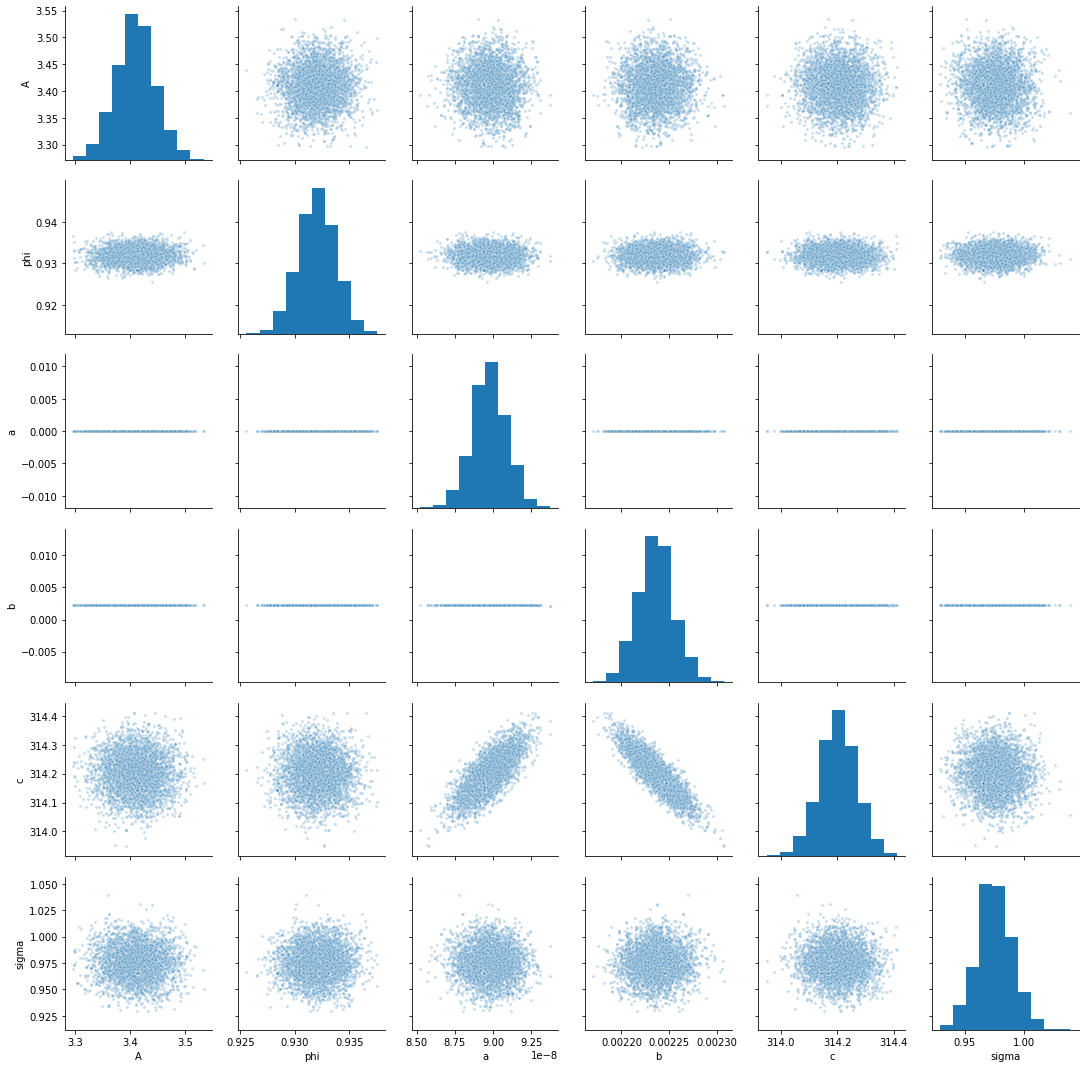

In [20]:
df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

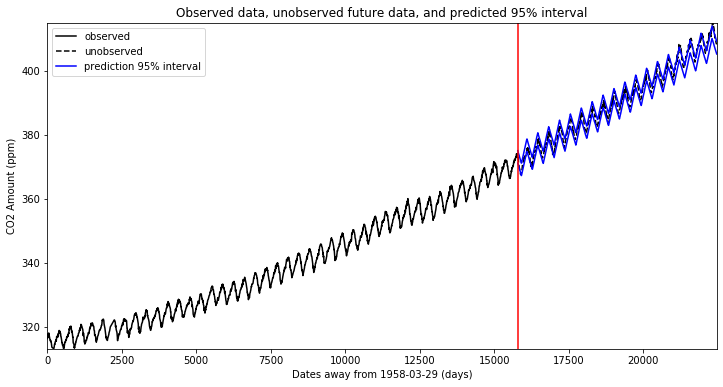

In [21]:
prediction = samples['x_future']

# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(data["Time"][:n], data["Amount"][:n], 'k-', label='observed')
plt.plot(data["Time"][n:n+n_future], data["Amount"][n:n+n_future], 'k--', label='unobserved')
plt.xlim(0, data["Time"][n+n_future-1])

# set scaling
plt.ylim(
    min(min(prediction[0,:]), min(data["Amount"])),
    max(max(prediction[1,:]), max(data["Amount"])))

# plot confidence interval
plt.plot(
    data["Time"][n:],
    prediction_interval[0,:],
    'b-', label='prediction 95% interval')
plt.plot(
    data["Time"][n:],
    prediction_interval[1,:],
    'b-')

plt.axvline(data["Time"][n - 1], color='red')
plt.xlabel("Dates away from 1958-03-29 (days)")
plt.ylabel("CO2 Amount (ppm)")
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()

In [0]:
# we store this sampling for later comparison
saw_prediction_interval = prediction_interval
saw_prediction = prediction


### **Model Comparison**

In [23]:
# confidence interval width comparison
saw_interval_length = saw_prediction_interval[1:,][0] - saw_prediction_interval[0:,][0]
cos_interval_length = cos_prediction_interval[1:,][0] - cos_prediction_interval[0:,][0]
rate = np.mean(saw_interval_length < cos_interval_length)*100
print("The percentage of the width of model 3 interval is smaller than of model 2 interval: {}%".format(rate))

The percentage of the width of model 3 interval is smaller than of model 2 interval: 100.0%


#### **Accuracy testing**

In [24]:
# the real data to validate
validate = np.array(data["Amount"][n:])

# the mean of prediction
saw_mean = np.mean(saw_prediction, axis = 0)
cos_mean = np.mean(cos_prediction, axis = 0)

# compute the SME errors
saw_SME = np.mean((saw_mean - validate)**2)
cos_SME = np.mean((cos_mean - validate)**2)
saw_all_SME = np.mean((saw_prediction - validate)**2)
cos_all_SME = np.mean((cos_prediction - validate)**2)

print("Sawtooth SME wrt to samples mean:", saw_SME)
print("Cos SME wrt to samples mean:", cos_SME)
print("Sawtooth SME wrt to all samples values:", saw_all_SME)
print("Cos SME wrt to all samples values:", cos_all_SME)

Sawtooth SME wrt to samples mean: 1.612156603044492
Cos SME wrt to samples mean: 2.1612224291754356
Sawtooth SME wrt to all samples values: 2.5857090803350777
Cos SME wrt to all samples values: 3.824635218251834


### **Test statistics**

As discussed above, we use the first 70% of the data (2197 values) as data for computing the posterior distributions over the parameters above using Stan. We use the other 30% of the data (the next 942 values) to test our prediction of future function values.

Our test statistic is the mean of future data: 942 last data points in the dataset. 

The reason is that: we suspect the model, even though overall fit the future data very well (based on the plot), fails to predict the few anomalies in the original data fully. For example, when we zoom in the first 600 data points in the test future data, we can see at those peaks, our real data is slightly off compared to the predicted interval. 

As the mean is sensitive to the outliers, we would expect the mean for the real future data to be in the upper or bottom percentile of the test statistics results of the sampled data.

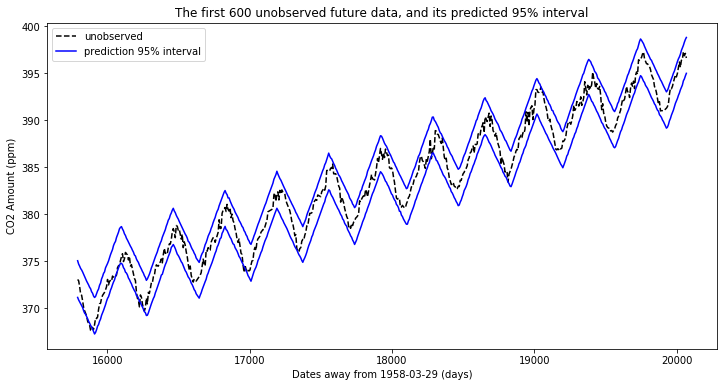

In [25]:
# zoom in the data for the first 600 points
plt.figure(figsize = (12,6))
plt.plot(data["Time"][n:n+600], data["Amount"][n:n+600], 'k--', label='unobserved')
plt.plot(
    data["Time"][n:n+600],
    prediction_interval[0,:][:600],
    'b-', label='prediction 95% interval')
plt.plot(
    data["Time"][n:n+600],
    prediction_interval[1,:][:600],
    'b-')
plt.xlabel("Dates away from 1958-03-29 (days)")
plt.ylabel("CO2 Amount (ppm)")
plt.legend()
plt.title('The first 600 unobserved future data, and its predicted 95% interval')
plt.show()

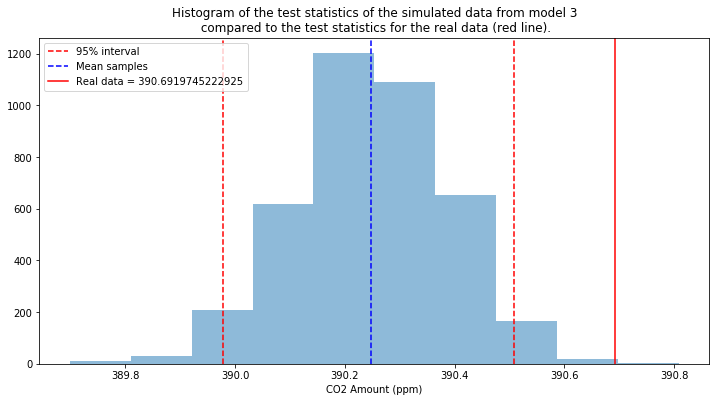

percentage result > real statistic value:  0.1 %
p value:  0.999


In [26]:
# test statistics: mean of samples
mean_samples = np.mean(saw_prediction, axis = 1)
benchmark = np.mean(data["Amount"][n:])

# plot the histogram of the test statistics
plt.figure(figsize = (12,6))
plt.hist(mean_samples, alpha = 0.5)
plt.axvline(np.quantile(mean_samples, 0.025), color='red', label ="95% interval", linestyle = "--")
plt.axvline(np.quantile(mean_samples, 0.975), color='red', linestyle = "--")
plt.axvline(np.mean(mean_samples), color='blue', linestyle = "--", label = "Mean samples")
plt.axvline(benchmark, color='red', label ="Real data = " + str(benchmark))
plt.xlabel("CO2 Amount (ppm)")
plt.title("Histogram of the test statistics of the simulated data from model 3\n compared to\
 the test statistics for the real data (red line).")
plt.legend()
plt.show()

final = np.mean(mean_samples > benchmark)
print("percentage result > real statistic value: ", final*100, "%")
print("p value: ", 1-final)

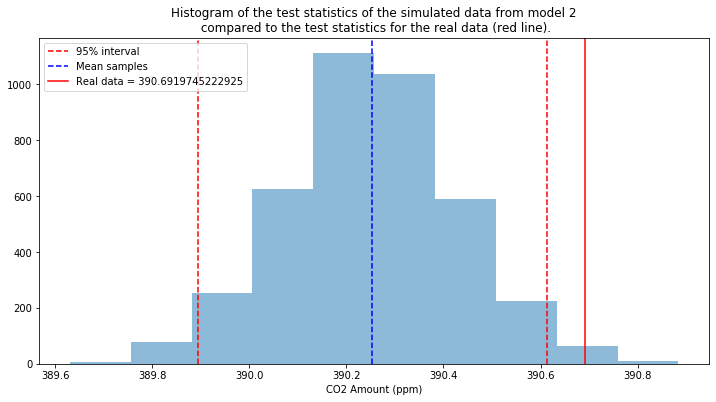

percentage result > real statistic value:  0.7250000000000001 %
p value:  0.99275


In [27]:
# test statistics: mean of samples
mean_samples = np.mean(cos_prediction, axis = 1)
benchmark = np.mean(data["Amount"][n:])

# plot the histogram of the test statistics
plt.figure(figsize = (12,6))
plt.hist(mean_samples, alpha = 0.5)
plt.axvline(np.quantile(mean_samples, 0.025), color='red', label ="95% interval", linestyle = "--")
plt.axvline(np.quantile(mean_samples, 0.975), color='red', linestyle = "--")
plt.axvline(np.mean(mean_samples), color='blue', linestyle = "--", label = "Mean samples")
plt.axvline(benchmark, color='red', label ="Real data = " + str(benchmark))
plt.xlabel("CO2 Amount (ppm)")
plt.title("Histogram of the test statistics of the simulated data from model 2\n compared to\
 the test statistics for the real data (red line).")
plt.legend()
plt.show()

final = np.mean(mean_samples > benchmark)
print("percentage result > real statistic value: ", final*100, "%")
print("p value: ", 1-final)

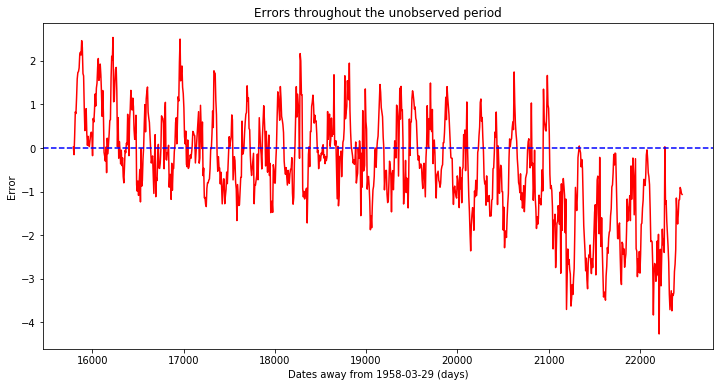

In [28]:
# the mean of errors by time
error_by_time = np.mean(saw_prediction - validate, axis = 0)

# plot
plt.figure(figsize = (12,6))
plt.plot(data["Time"][n:], error_by_time, 'r-', label = "error")
plt.axhline(0, color = "blue", linestyle = "--")
plt.xlabel("Dates away from 1958-03-29 (days)")
plt.ylabel("Error")
plt.title('Errors throughout the unobserved period')
plt.show()

Median: -0.39648976903481525
95% Interval: [-3.63786624  2.4763771 ]


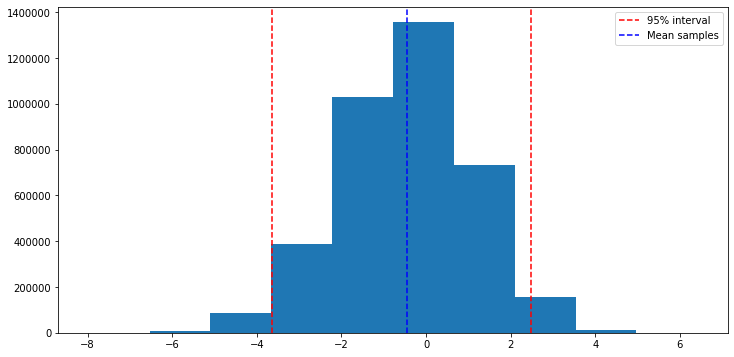

In [30]:
# combine of every errors
error_sets = (saw_prediction - validate).flatten()
print("Median:", np.median(error_sets))
print("95% Interval:", np.quantile(error_sets, [0.025, 0.975]))

# plot
plt.figure(figsize = (12,6))
plt.hist(error_sets)
plt.axvline(np.quantile(error_sets, 0.025), color='red', label ="95% interval", linestyle = "--")
plt.axvline(np.quantile(error_sets, 0.975), color='red', linestyle = "--")
plt.axvline(np.mean(error_sets), color='blue', linestyle = "--", label = "Mean samples")
plt.legend()
plt.show()

### **Predictions**

In [0]:
# the dates need for calculation: 1st date of data, end date of data, 2058 dates (start and end)
first_date = datetime.datetime.strptime(data["Date"][0], "%Y-%m-%d")
last_date = datetime.datetime.strptime(data["Date"][len(data)-1], "%Y-%m-%d")
desire_first = datetime.datetime.strptime("2058-01-01", "%Y-%m-%d")
desire_last = datetime.datetime.strptime("2058-12-31", "%Y-%m-%d")

# convert into readable dates by pystan
stop1 = (desire_first - first_date).days//7+1
stop2 = (desire_last - first_date).days//7
start = (last_date - first_date).days/7

# generate the future time parameters
new_time = np.array(list(range(int(start + 1), int(start + 1) + int(40*365.25//7))))*7
new_time = list(new_time)

In [32]:
# rerun the model with all the data to predict the future
n = len(data)
n_future = len(new_time)

stan_data = {
    'n': n,
    'n_future': n_future,
    'x': data["Amount"],
    't': data["Time"],
    "t_future" : new_time}

# Run Hamiltonian Monte Carlo using Stan with 4 Markov chains, a 1000 step
# warm-up phase and 1000 step sampling phase for each chain. The warm-up samples
# are discarded, so we are left with 4 x 1000 = 4000 samples.

# This cell will take a minute or two to run.

parameters = ['A', 'phi', 'log_a', 'b', 'c', "sigma"]

results = stan_model.sampling(data=stan_data)
print(results.stansummary(pars=parameters))
samples = results.extract()

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_e495cf1d5c27bdec1a1bdddf6401e82a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
A       3.49  7.2e-4   0.03   3.43   3.47   3.49   3.51   3.55   1939    1.0
phi     0.94  2.2e-5 1.4e-3   0.93   0.93   0.94   0.94   0.94   4093    1.0
log_a -16.15  1.2e-4 5.1e-3 -16.16 -16.15 -16.15 -16.15 -16.14   1665    1.0
b     2.1e-3  2.8e-7 1.1e-5 2.1e-3 2.1e-3 2.1e-3 2.1e-3 2.1e-3   1696    1.0
c     314.56  1.2e-3   0.06 314.45 314.52 314.56  314.6 314.67   2152    1.0
sigma    1.0  3.0e-4   0.01   0.98   0.99    1.0   1.01   1.03   1881    1.0

Samples were drawn using NUTS at Wed Dec 18 14:32:04 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


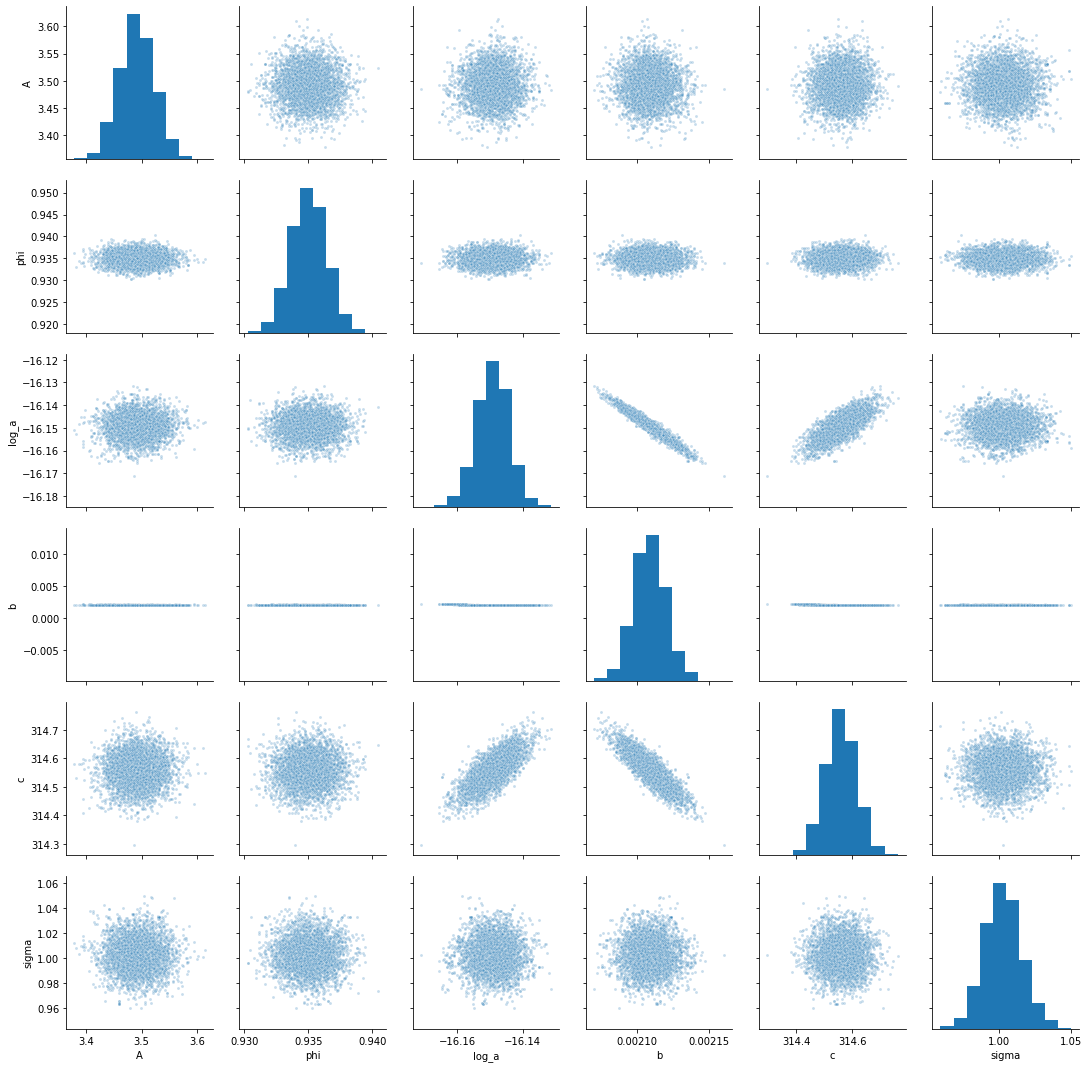

In [33]:
# pair plots
df = pd.DataFrame(
    data=np.transpose([samples[param] for param in parameters]),
    columns=parameters)
seaborn.pairplot(df, height=2.5, plot_kws={'marker': '.', 'alpha': 0.25})
plt.show()

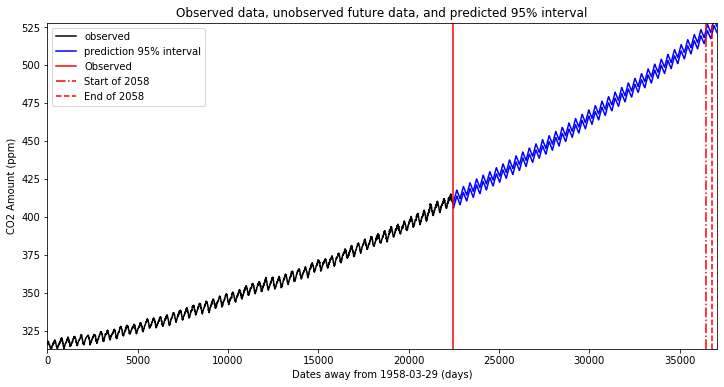

In [34]:
prediction = samples['x_future']

# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
plt.plot(data["Time"], data["Amount"], 'k-', label='observed')
plt.xlim(0, max(new_time))
plt.ylim(
    min(min(prediction[0,:]), min(data["Amount"])),
    max(max(prediction[1,:]), max(data["Amount"])))

plt.plot(
    new_time,
    prediction_interval[0,:],
    'b-', label='prediction 95% interval')

plt.plot(
    new_time,
    prediction_interval[1,:],
    'b-')

plt.axvline(data["Time"][n - 1], color='red', label = "Observed")
plt.axvline(stop1 * 7, color = "red", linestyle = "-.", label ="Start of 2058")
plt.axvline(stop2 * 7, color = "red", linestyle = "--", label ="End of 2058")
plt.xlabel("Dates away from 1958-03-29 (days)")
plt.ylabel("CO2 Amount (ppm)")
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()

#### year 2058

Mean of the estimate: 519.5246199645143
Median of the estimate: 519.5167440251244
STD of the estimate: 1.05966781226145
Confidence interval in 2058: [517.474873011385, 521.5981563346509]


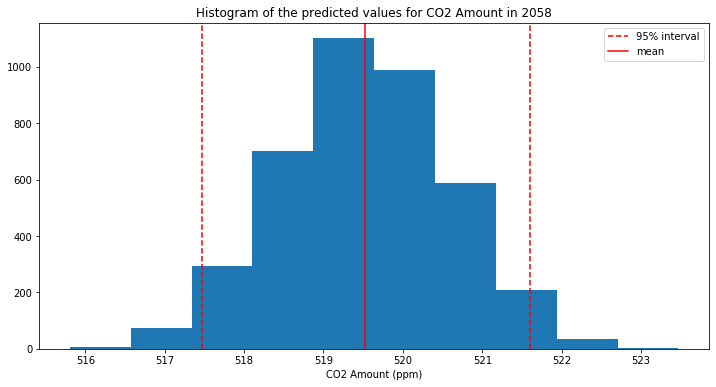

In [35]:
# Get data for this specific measurement and compute the statistics
sample_2058 = prediction.T[int(stop1-start)-1]
print("Mean of the estimate: {}".format(np.mean(sample_2058)))
print("Median of the estimate: {}".format(np.median(sample_2058)))
print("STD of the estimate:", np.std(sample_2058))
lower_2058 = prediction_interval[0,:][int(stop1-start)-1]
upper_2058 = prediction_interval[1,:][int(stop1-start)-1]
print("Confidence interval in 2058: [{}, {}]".format(lower_2058, upper_2058))

# plot the results
plt.figure(figsize = (12,6))
plt.hist(sample_2058)
plt.xlabel("CO2 Amount (ppm)")
plt.title("Histogram of the predicted values for CO2 Amount in 2058")
plt.axvline(lower_2058, color = "red", linestyle = "--")
plt.axvline(upper_2058, color = "red", linestyle = "--", label = "95% interval")
plt.axvline(np.mean(sample_2058), color = "red", linestyle = "-", label = "mean")
plt.legend()
plt.show()

In [36]:
# the probabilities of certain dates > 450 ppm
probability = np.mean(prediction.T >= 450, axis = 1)

# first value to have 1.0 probability
idx_100 = next(x[0] for x in enumerate(list(probability)) if x[1] >= 1)

# first value to have 0.5 probability
idx_50 = next(x[0] for x in enumerate(list(probability)) if x[1] >= 0.5)

# first value to have all values onward = 1.0
for i in range(len(probability)):
  if np.mean(probability[i:]) == 1:
    idx_full_100 = i
    break

# first value to have all values onward >= 0.5
for i in range(len(probability)):
  if np.mean(probability[i:] >= 0.5) == 1:
    idx_full_50 = i
    break

print("1st date to have 0.5 probability:", timedelta(idx_50*7) + last_date)
print("1st date to have 1.0 probability:", timedelta(idx_100*7) + last_date)
print("1st date to have all 0.5 probability onward:", timedelta(idx_full_50*7) + last_date)
print("1st date to have all 1.0 probability onward:", timedelta(idx_full_100*7) + last_date)

1st date to have 0.5 probability: 2034-03-18 00:00:00
1st date to have 1.0 probability: 2035-04-07 00:00:00
1st date to have all 0.5 probability onward: 2035-11-17 00:00:00
1st date to have all 1.0 probability onward: 2036-11-29 00:00:00


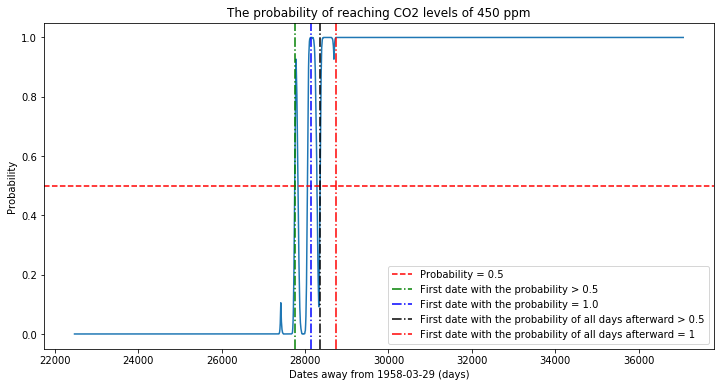

In [37]:
# plot the probability
plt.figure(figsize = (12,6))
plt.plot(new_time,probability)
plt.xlabel("Dates away from 1958-03-29 (days)")
plt.ylabel("Probability")
plt.axhline(0.5, color = "red", linestyle = "--", label = "Probability = 0.5")
plt.axvline(idx_50 * 7 + data["Time"][n - 1], color = "green", linestyle = "-.", label ="First date with the probability > 0.5")
plt.axvline(idx_100 * 7 + data["Time"][n - 1], color = "blue", linestyle = "-.", label ="First date with the probability = 1.0")
plt.axvline(idx_full_50 * 7 + data["Time"][n - 1], color = "black", linestyle = "-.", label ="First date with the probability of all days afterward > 0.5")
plt.axvline(idx_full_100 * 7 + data["Time"][n - 1], color = "red", linestyle = "-.", label ="First date with the probability of all days afterward = 1")
plt.title("The probability of reaching CO2 levels of 450 ppm")
plt.legend()
plt.show()

#### All plot at once

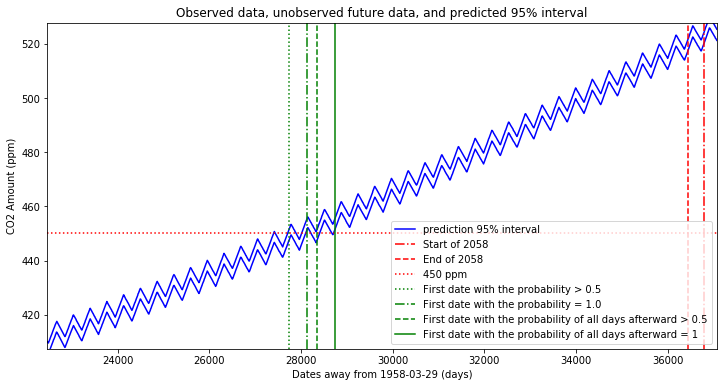

In [40]:
prediction = samples['x_future']

# Compute 95% interval of the predicted values
prediction_interval = np.percentile(prediction, axis=0, q=[2.5, 97.5])

# Plot mean and 95% interval of predictions
plt.figure(figsize=(12, 6))
# plt.plot(data["Time"], data["Amount"], 'k-', label='observed')
plt.xlim(data["Time"][n - 1], max(new_time))
plt.ylim(
    min(prediction[0,:]),
    max(prediction[1,:]))

plt.plot(
    new_time,
    prediction_interval[0,:],
    'b-', label='prediction 95% interval')

plt.plot(
    new_time,
    prediction_interval[1,:],
    'b-')

plt.axvline(stop2 * 7, color = "red", linestyle = "-.", label ="Start of 2058")
plt.axvline(stop1 * 7, color = "red", linestyle = "--", label ="End of 2058")
plt.axhline(450, color = "red", linestyle = ":", label = "450 ppm")
plt.axvline(idx_50 * 7 + data["Time"][n - 1], color = "green", linestyle = ":", label ="First date with the probability > 0.5")
plt.axvline(idx_100 * 7 + data["Time"][n - 1], color = "green", linestyle = "-.", label ="First date with the probability = 1.0")
plt.axvline(idx_full_50 * 7 + data["Time"][n - 1], color = "green", linestyle = "--", label ="First date with the probability of all days afterward > 0.5")
plt.axvline(idx_full_100 * 7 + data["Time"][n - 1], color = "green", linestyle = "-", label ="First date with the probability of all days afterward = 1")

plt.xlabel("Dates away from 1958-03-29 (days)")
plt.ylabel("CO2 Amount (ppm)")
plt.legend()
plt.title('Observed data, unobserved future data, and predicted 95% interval')
plt.show()